## Import libraries, load pkl file, standardized functions

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.interpolate
import time
from scipy.signal import savgol_filter

In [2]:
superhist = "histdataset1.pkl"
with open(superhist, "rb") as f:
    ds = pkl.load(f)

keys = ds.keys()
print(keys)

#in making the superhistogram, I only saved the data between 26500 and 103000 (see makehist line 237) 
#making the first bin 26500 as the left edge 

countarr = ds["C10"] #strictly the compiled im_arr of all the images 
mbins = np.arange(26500, 26500+len(countarr)) #built into the dataset 

start = np.argwhere(mbins == 30000)

termcountarr = countarr[start[0][0]:] #this starts histogram at 30,000
termbins = mbins[start[0][0]:] #this is the adc codes which this is valid for

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])


In [3]:
def examineinl(edges, binsnum, edgemethodname): #here binsnum is binnumbers 
    idealmids = 0.5 + binsnum    
    adcmids = [sum(i) for i in zip(edges[1:], edges[:-1])] #add together elements
    adcmids[:] = [x / 2 for x in adcmids] #find their mean, verified 3 entires, sufficient
    arraymids = np.array(adcmids)*(-1) 
    inl = [sum(i) for i in zip(idealmids, arraymids)]
    plt.plot(binsnum, inl)
    plt.title(f'{edgemethodname} inl by bin number')
    plt.xlabel("bin number")
    plt.ylabel("inl")
    plt.grid()
    return inl 

def makenarrow(bcvar, right, left):
    width = right - left
    width *= (1-bcvar) #reduce the lenght of the bin 
    right = width + left 
    bcvar *= 0.85 #make the change amount reduced by 50% 
    return right, bcvar
    
def makewide(bcvar, right, left): #function increases the bin width 
    width = right - left
    width *= (1+bcvar)
    right = width + left 
    bcvar *= 0.85 
    return right, bcvar

def buildedges(cs, counts): #reduces
    edges = [30000] #define the first edge to be 30k 
    for a in range(len(counts)): 
        left = edges[-1]
        if left > 103000: #prevent interpolation beyond what we have for values
            break
        inte = scipy.interpolate.CubicSpline.integrate(cs, left, left+1) #generically make the width = 1        
        right = left + 1 
        x = 0 #a counter for issues 
        bcvar = 0.25 #bin change variable (start with 25% change)
        while len(edges) != a+2: 
            if counts[a]-0.01 < inte < counts[a] +0.01: #make the requirement sufficient
                edges.append(right)  
            elif counts[a] > inte: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                inte = scipy.interpolate.CubicSpline.integrate(cs, left, right)       
            elif counts[a] < inte:  #bin is too big
                right, bcvar = makenarrow(bcvar, right, left)
                inte = scipy.interpolate.CubicSpline.integrate(cs, left, right)
            x +=1 
    return edges

## Original method 
cubic spline function onto the savgol filtered datapoints

In [4]:
smoothed = savgol_filter(termcountarr, 33, 3)
cs = scipy.interpolate.CubicSpline(termbins, smoothed) #spline fitting for the smoothed values
csx = np.arange(30000, 30000+len(termbins), 0.1)

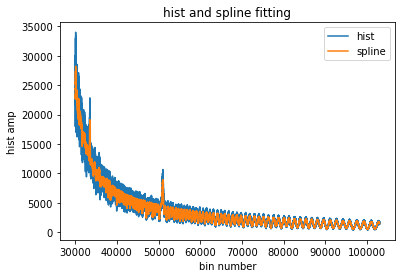

In [5]:
plt.plot(termbins, termcountarr, label="hist")
plt.plot(csx, cs(csx), label="spline")
plt.title("hist and spline fitting")
plt.xlabel("bin number")
plt.ylabel("hist amp")
plt.legend()

In [6]:
edges = buildedges(cs, termcountarr) 

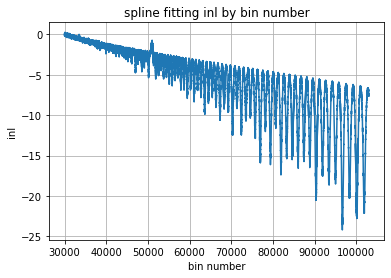

In [7]:
bins = 30000 + np.arange(0, len(edges)-1)
inl = examineinl(edges, bins, "spline fitting")

In [8]:
print("the largest inl is,", min(inl))

the largest inl is, -24.217108745418955


In [9]:
## check the totals

splineint = scipy.interpolate.CubicSpline.integrate(cs, termbins[0], termbins[-1]) 
print("the spline integral", splineint)

total = sum(termcountarr[:-1]) #add every element in the list, except the last one 
print("the hist sum is", total)

totalsavgol = sum(smoothed[:-1]) #add every element in the list, except the last one 
print("the savgol sum is:", totalsavgol)
print("")

print('spline - sumhist:', splineint-total)
print("savgol - sumhist:", totalsavgol-total)
print("")

print("hist sum > savgol > spline")

the spline integral 272847722.5857706
the hist sum is 272859461
the savgol sum is: 272858709.2578698

spline - sumhist: -11738.414229393005
savgol - sumhist: -751.7421302199364

hist sum > savgol > spline


## Correct the smoothed distribution

In [10]:
smoothed2 = savgol_filter(termcountarr, 33, 3)

correction = sum(termcountarr)/ sum(smoothed2)
print(correction)
smoothed2 *= correction

1.000002736877625


In [11]:
cs2 = scipy.interpolate.CubicSpline(termbins, smoothed2) #spline fitting for the smoothed values

In [12]:
edges2 = buildedges(cs2, termcountarr)

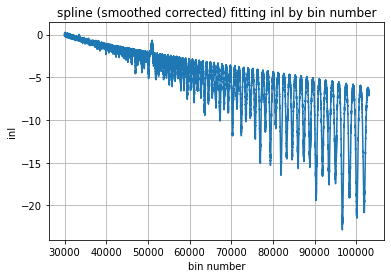

In [13]:
bins2 = 30000 + np.arange(0, len(edges2)-1)
inl2 = examineinl(edges2, bins2, "spline (smoothed corrected) fitting")

In [14]:
print("the largest inl is,", min(inl2))
print("this has decreased")

the largest inl is, -22.85968871273508
this has decreased


In [15]:
## check the totals

splineint = scipy.interpolate.CubicSpline.integrate(cs2, termbins[0], termbins[-1]) 
print("the spline integral", splineint)

total = sum(termcountarr[:-1]) #add every element in the list, except the last one 
print("the hist sum is", total)

totalsavgol = sum(smoothed2[:-1])
print("the savgol sum is:", totalsavgol)
print("")

print('spline - sumhist:', splineint-total)
print("savgol - sumhist:", totalsavgol-total)
print("")

print("hist sum > savgol > spline")

the spline integral 272848469.3365998
the hist sum is 272859461
the savgol sum is: 272859456.0387651

spline - sumhist: -10991.663400173187
savgol - sumhist: -4.961234927177429

hist sum > savgol > spline


even with a correction to the smoothed we still have a difference between the hist sum and the spline fitting. the spline fitting is underestimating consistently. Which is not good, both that it does not recover the smoothed distribution and more importantly the histogram output. 

## Instead correct the spline fitting

In [16]:
#terminate below 30k
#add a factor for correction to the spline 

smoothed3 = savgol_filter(termcountarr, 33, 3)

cs3 = scipy.interpolate.CubicSpline(termbins, smoothed3)

inte = scipy.interpolate.CubicSpline.integrate(cs3, termbins[0], termbins[-1])

corr = sum(termcountarr[:-1])/ inte
print(corr)

## correct the number of counts by dividing by corr factor 

termcountarr2 = termcountarr/corr 

1.000043021851596


In [17]:
edges3 = buildedges(cs3, termcountarr2)

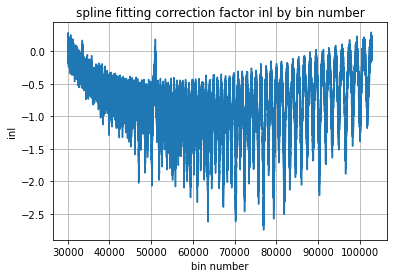

In [18]:
bins3 = 30000 + np.arange(0, len(edges3)-1)
inl3 = examineinl(edges3, bins3, "spline fitting correction factor")

In [19]:
print(min(inl3))
print("this has decreased")

-2.748472626786679
this has decreased


In [20]:
## check the totals

splineint = scipy.interpolate.CubicSpline.integrate(cs3, termbins[0], termbins[-1]) 
print("the spline integral", splineint)

total = sum(termcountarr2[:-1]) #add every element in the list, except the last one 
print("the hist sum is", total)

totalsavgol = sum(smoothed3[:-1])
print("the savgol sum is:", totalsavgol)
print("")

print('spline - sumhist:', splineint-total)
print("savgol - sumhist:", totalsavgol-total)
print("")

print("hist sum > spline > savgol")

the spline integral 272847722.5857706
the hist sum is 272847722.58577305
the savgol sum is: 272858709.2578698

spline - sumhist: -2.4437904357910156e-06
savgol - sumhist: 10986.672096729279

hist sum > spline > savgol
